# A/B-тестирование.

**Цель исследования.**

- Нужно приоритизировать гипотезы из списка;
- Запустить A/B-тест и проанализировать его результаты;
- Рассмотрим стабильность графиков таких кумулятивных метрик, как:
  - выручка по группам; 
  - средний чек по группам; 
  - изменение кумулятивного среднего чека группы B к группе A; 
  - относительного изменения кумулятивного среднего количества заказов на посетителя между группами;
  - график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A;
- Посмотрим на точечный график количества заказов по пользователям и стоимостей заказов;
- Оценим процент данных, выступающих в качестве выбросов;
- Используем непараметрический тест Уилкоксона-Манна-Уитни для анализа A/B теста таких метрик, как:
  - статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным;
  - статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным;
  - статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным;
  - статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

**Имеющиеся данные.**

В нашем распоряжении 3 датасета. Файл /datasets/hypothesis.csv, содержащий список гипотез; /datasets/orders.csv, хранящий информацию о заказах пользователей в интернет-магазине; /datasets/visitors.csv, содержащий информацию о посещениях пользователями интернет-магазина

**Данные для первой части.**

**Структура /datasets/hypothesis.csv:**

-  Hypothesis — краткое описание гипотезы;
-  Reach — охват пользователей по 10-балльной шкале;
-  Impact — влияние на пользователей по 10-балльной шкале;
-  Confidence — уверенность в гипотезе по 10-балльной шкале;
-  Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка        гипотезы.
    
**Данные для второй части.**

**Структура /datasets/orders.csv:**

-   transactionId — идентификатор заказа;
-   visitorId — идентификатор пользователя, совершившего заказ;
-   date — дата, когда был совершён заказ;
-   revenue — выручка заказа;
-   group — группа A/B-теста, в которую попал заказ.
        
**Структура /datasets/visitors.csv:**

-   date — дата;
-   group — группа A/B-теста;
-   visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

**План работы:**

-   1. Обзор и предобработка данных;
-   2. Приоритизация гипотез;
-   3. Анализ А/В-теста;
-   4. Вывод.

### Обзор и предобработка данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import scipy.stats as stats
from scipy import stats as st
import warnings

In [2]:
# игнорируем предупреждения
warnings.filterwarnings(action='ignore')

# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.3f}'.format

# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

#ставим ограничение на показ максимума строк, равное 100
pd.options.display.max_rows = 100

# задаем размер графика
sns.set(rc={'figure.figsize':(9,5)})

In [3]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors  = pd.read_csv('/datasets/visitors.csv')

**Используем функцию для подробного изучения датасетов, заодно приведём к общему виду столбцы, подсчитаем дубликаты и поменяем тип данных.**

In [4]:
def inspect(df):
    display(df.head()) 
    df.info() 
    print ('Количество дубликатов -', df.duplicated().sum())
    numeric_columns=df.describe().columns
    display(df.describe())
    display()
    df.columns = [x.lower().replace(' ', '_') for x in df.columns.values]
    for column_name in df.columns:
        if column_name not in numeric_columns:
            if 'date' in column_name or 'dt' in column_name:
                df[column_name] = pd.to_datetime(df[column_name])
            else:
                display(df[column_name].value_counts())
                print(50*'*')
    return df

In [5]:
hypothesis = inspect(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
Количество дубликатов - 0


,Reach,Impact,Confidence,Efforts
count,9.000,9.000,9.000,9.000
mean,4.778,4.778,5.556,4.889
std,3.153,3.193,3.046,2.804
min,1.000,1.000,1.000,1.000
25%,3.000,3.000,3.000,3.000
50%,3.000,3.000,7.000,5.000
75%,8.000,7.000,8.000,6.000
max,10.000,10.000,9.000,10.000


Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа    1
Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей              1
Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов                        1
Запустить акцию, дающую скидку на товар в день рождения                                                         1
Запустить собственную службу доставки, что сократит срок доставки заказов                                       1
Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей                                1
Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок                1
Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию            1
Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут н

**************************************************


3     3
8     2
1     1
2     1
5     1
10    1
Name: reach, dtype: int64

**************************************************


3     3
1     1
2     1
5     1
7     1
9     1
10    1
Name: impact, dtype: int64

**************************************************


8    3
1    1
2    1
3    1
4    1
7    1
9    1
Name: confidence, dtype: int64

**************************************************


3     3
5     2
1     1
6     1
8     1
10    1
Name: efforts, dtype: int64

**************************************************


In [6]:
orders = inspect(orders)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
Количество дубликатов - 0


,transactionId,visitorId,revenue
count,"1,197.000","1,197.000","1,197.000"
mean,"2,155,621,385.530","2,165,960,143.099","8,348.006"
std,"1,229,084,904.760","1,236,014,192.147","39,191.132"
min,"1,062,393.000","5,114,589.000",50.000
25%,"1,166,775,572.000","1,111,826,046.000","1,220.000"
50%,"2,145,193,898.000","2,217,984,702.000","2,978.000"
75%,"3,237,740,112.000","3,177,606,451.000","8,290.000"
max,"4,293,855,558.000","4,283,872,382.000","1,294,500.000"


1658608862    1
2211880073    1
3913205113    1
437656952     1
3592105335    1
             ..
2872509092    1
2013919907    1
3154167297    1
2960804513    1
4281129020    1
Name: transactionid, Length: 1197, dtype: int64

**************************************************


4256040402    11
2458001652    11
2378935119     9
2038680547     8
199603092      5
              ..
2406916810     1
1255412427     1
3866069709     1
54447517       1
3013339133     1
Name: visitorid, Length: 1031, dtype: int64

**************************************************


B    640
A    557
Name: group, dtype: int64

**************************************************


In [7]:
orders = orders.rename (columns= {'transactionid': 'transaction_id', 'visitorid': 'visitor_id'})

In [8]:
visitors = inspect(visitors)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
Количество дубликатов - 0


,visitors
count,62.000
mean,607.290
std,114.401
min,361.000
25%,534.000
50%,624.500
75%,710.500
max,770.000


B    31
A    31
Name: group, dtype: int64

**************************************************


In [9]:
print(orders['date'].min())
print(orders['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00


In [10]:
print(orders.loc[orders['group']=='A', 'revenue'].sum())
print(orders.loc[orders['group']=='B', 'revenue'].sum())
print('Процент выручки группы B от общего количества:',orders.loc[orders['group']=='B', 'revenue'].sum()/(orders.loc[orders['group']=='A', 'revenue'].sum()+orders.loc[orders['group']=='A', 'revenue'].sum()))

4084803
5907760
Процент выручки группы B от общего количества: 0.7231389126966465


In [11]:
orders['visitor_id'].value_counts()

4256040402    11
2458001652    11
2378935119     9
2038680547     8
199603092      5
              ..
2406916810     1
1255412427     1
3866069709     1
54447517       1
3013339133     1
Name: visitor_id, Length: 1031, dtype: int64

**Для того чтобы рассчитать вероятность для одного пользователя попасть в обе группы, мы можем воспользоваться формулой вероятности пересечения событий.**

**Предположим, что событие A - попадание пользователя в первую группу, а событие B - попадание пользователя во вторую группу. Вероятность пересечения этих событий можно вычислим по формуле:**

**P(A ∩ B) = P(A) * P(B|A)**

**,где P(A) - вероятность попадания одного пользователя в первую группу, P(B|A) - условная вероятность попадания пользователя во вторую группу при условии, что он уже попал в первую.**

**Мы знаем, что вероятность попадания пользователя в первую группу равна 32/1031, так как есть 32 места из 1097 посетителей. Для второй группы вероятность также равна 32/1031.**

**Теперь можем рассчитать вероятность пересечения событий:**

In [12]:
print('Вероятность случайного пользователя из выборки попасть в обе группы равна:', (32/1031) * (32/1031))

Вероятность случайного пользователя из выборки попасть в обе группы равна: 0.0009633467267378577


**Вывод.**

**Мы ознакомились с датафреймами.**

**Имеем 2 исследуемых группы пользователей по 31 человеку в каждой, тест проводился 1 календарный месяц с 1 августа 2019 года по  31 августа того же года. Пользователи из группы B совершили 640 заказов за месяц, из группы A - 557 заказов (на 6.5% меньше). Среднее суточное количество посещений сайта пользователями обоих групп равно 607. На пользователей из группы B пришлось 72,3% выручки за исследуемый период.**

**Пропуски и дубликаты не обнаружены, но кое-что требовало правки: тип данных в столбцах не везде корректный (столбцы с датами имели тип object). Изменили visitors['date'] и orders['date'] на 'datetime', также привели названия столбцов к общему виду.**

### Часть 1. Приоритизация гипотез.

#### Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [13]:
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000


**Видим топ-5 гипотез, которым следует уделить особое внимание. Добавим к расчету параметр Reach (англ.: Охват) и приоритезируем гипотезы по методу RICE.**

#### Применим фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [14]:
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000


**Видим те же самые гипотезы в топе, только в другой последовательности. Разница приоритизации заключается в том, что одна учитывает кол-во пользователей, которых затронут изменения, а другая - нет.**

### Часть 2. Анализ A/B-теста.

**Был проведён A/B-тест и получены результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.**
**Проанализируем его.**

**Чтобы построить графики по кумулятивным (накапливаемым) данным, нужно собрать агрегированный датафрейм, содержащий информацию о дате, группе (А или В), кумулятивном количестве заказов и пользователей, которые их оформили, среднем чеке и о кумулятивном количестве посетителей магазина.**

In [15]:
# создаем массив уникальных пар значений дат и групп теста
dates_grouped = orders[['date', 'group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
orders_grouped = dates_grouped.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

orders_grouped.head(6)

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
310,2019-08-03,B,61,59,380996


In [16]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 

visitors_grouped = dates_grouped.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max', 
            'group': 'max', 
            'visitors': 'sum'
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitors_grouped.head(6)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
310,2019-08-03,B,1803


In [17]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия

cumulative_data = orders_grouped.merge(
    visitors_grouped, 
    left_on=['date', 'group'], 
    right_on=['date', 'group']
)

cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [18]:
#добавим колонку с конверсией
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data.head(6)

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033
1,2019-08-01,B,21,20,101217,713,0.029
2,2019-08-02,A,44,38,242401,1338,0.033
3,2019-08-02,B,45,43,266748,1294,0.035
4,2019-08-03,A,68,62,354874,1845,0.037
5,2019-08-03,B,61,59,380996,1803,0.034


#### Построим график кумулятивной выручки по группам.

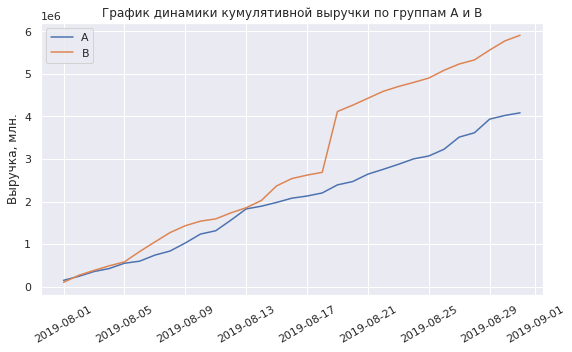

In [19]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')
plt.title('График динамики кумулятивной выручки по группам А и В')
plt.ylabel("Выручка, млн.")
plt.xticks(rotation=30)
plt.legend()
plt.show()

**Видно, что кумулятивная выручка группы А растет линейно, и она меньше, чем у группы В.
При этом в группе В есть резкий скачок в районе 18-го августа, что может говорить о возросшем числе заказов, либо о появлении очень дорогих заказов в выборке.**

#### Построим график кумулятивного среднего чека по группам.

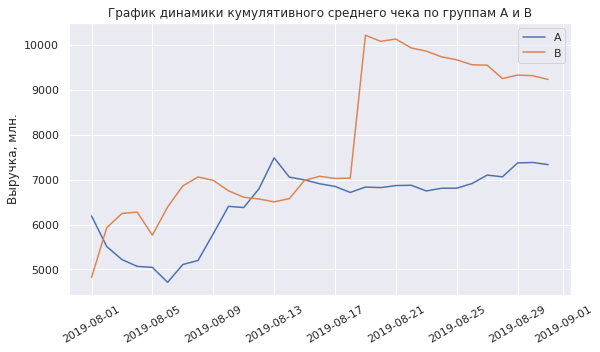

In [20]:
plt.plot(cumulative_revenue_a['date'], 
         cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'],
         label='A')

plt.plot(cumulative_revenue_b['date'], 
         cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'], 
         label='B')

plt.title('График динамики кумулятивного среднего чека по группам А и В')
plt.ylabel("Выручка, млн.")
plt.xticks(rotation=30)
plt.legend()
plt.show()

**Видим, что средний чек в группе А через какое-то время стабилизировался. Средний чек группы В показал резкий рывок, что говорит в пользу версии о дорогой покупке.**

#### Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

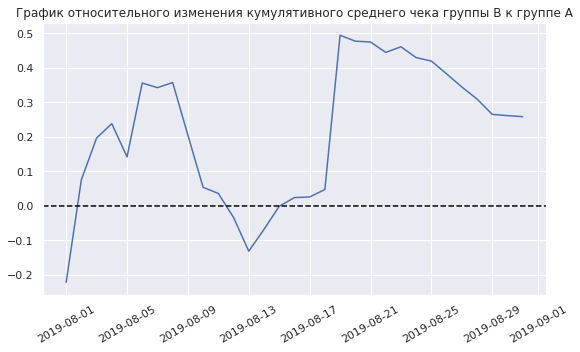

In [21]:
# собираем данные в одном датафрейме
cumulative_revenue_ab = cumulative_revenue_a.merge(
    cumulative_revenue_b, 
    left_on='date', 
    right_on='date', 
    how='left', 
    suffixes=['_a', '_b']
)

# cтроим отношение средних чеков
plt.plot(cumulative_revenue_ab['date'], 
         (
             cumulative_revenue_ab['revenue_b']/cumulative_revenue_ab['orders_b']
         )/
         (
             cumulative_revenue_ab['revenue_a']/cumulative_revenue_ab['orders_a']
         )-1
        )

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xticks(rotation=30)
plt.show()

**График резко скачет в нескольких точках, что намекает на наличие выбросов и/или крупных заказов.**

#### Построим график кумулятивного среднего количества заказов на посетителя по группам.

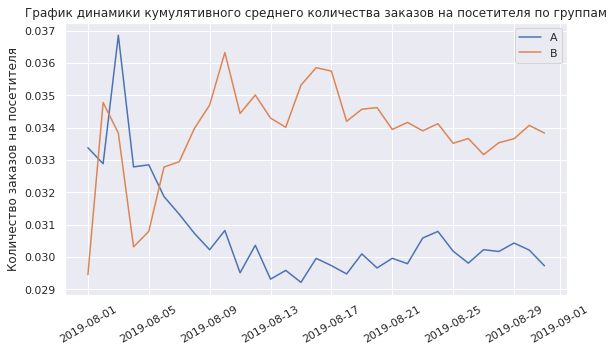

In [22]:
ordersAggregated = dates_grouped.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = dates_grouped.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 
            'group': 'max', 
            'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])
# считаем среднее количество заказов на посетителя
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График динамики кумулятивного среднего количества заказов на посетителя по группам')
plt.ylabel("Количество заказов на посетителя")
plt.xticks(rotation=30)
plt.legend()
plt.show()

**Сначала среднее количество заказов на посетителя колебалось, но довольно быстро выровнялись. Везультат группы В выглядит более привлекательным.**

#### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

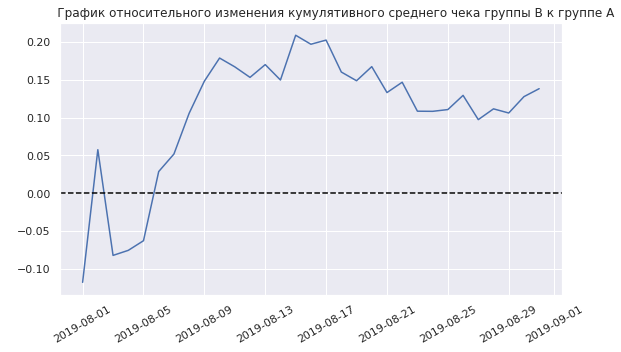

In [23]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.title('             График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xticks(rotation=30)
plt.show()

**В начале теста группа В проигрывала группе А, но затем вырвалась вперед. Ее куммулятивная метрика стремительно росла, далее начался медленный спад. Теперь среднее количество заказов группы В снова растет.
Помним, что графики выше сигнализировали нам о наличии крупных заказов.
Проанализируем данные после чистки от выбросов еще раз.**

#### Построим точечный график количества заказов по пользователям. 

count   1,031.000
mean        1.161
std         0.725
min         1.000
25%         1.000
50%         1.000
75%         1.000
max        11.000
Name: orders, dtype: float64

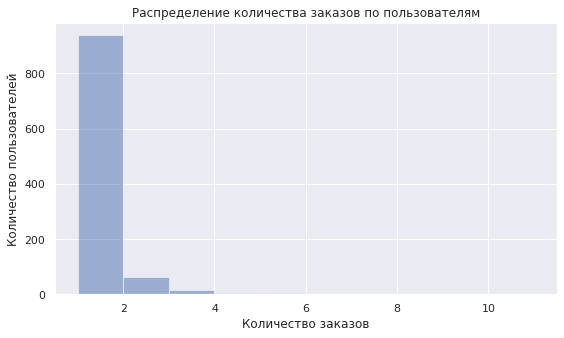

In [24]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns =  ['visitor_id', 'orders']
display(orders_by_users['orders'].describe())

# строим гистограмму
plt.hist(orders_by_users['orders'], alpha=0.5) 
plt.title('Распределение количества заказов по пользователям')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.show()

**Большинство пользователей оформляли заказ один раз, но есть и те, кто успел заказать за месяц 11 раз.**

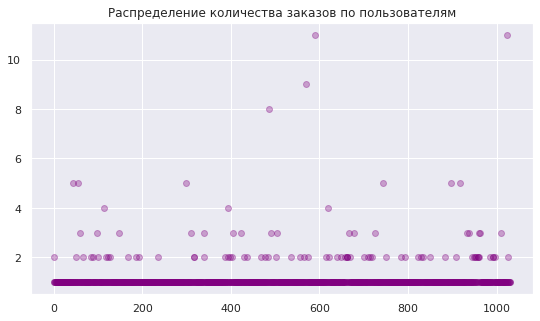

In [25]:
x_values = pd.Series(range(0,len(orders_by_users)))

# строим точечную диаграмму
plt.scatter(x_values, orders_by_users['orders'], color='purple', alpha=0.33)
plt.title('Распределение количества заказов по пользователям')
plt.show()

**Много пользователей с 2-3 заказами. Их точная доля не ясна, поэтому сложно понять, можно ли считать их выбросами или нет.
Посчитаем 95-й и 99-й перцентили количества заказов на пользователя и выберем границу для определения аномальных пользователей.**

#### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [26]:
np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

**Не более 5% пользователей совершали больше 2-х покупок в течение тестирования. И только 1% - четыре и более.
Примем за верхнюю границу 4 заказа на одного пользователя.**

#### Построим точечный график стоимостей заказов.

count       1,197.000
mean        8,348.006
std        39,191.132
min            50.000
25%         1,220.000
50%         2,978.000
75%         8,290.000
max     1,294,500.000
Name: revenue, dtype: float64

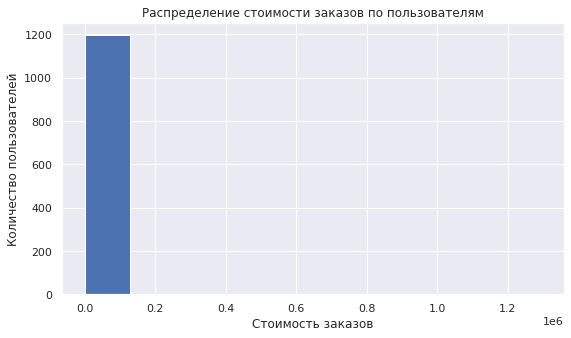

In [27]:
display(orders['revenue'].describe())

# строим гистограмму
plt.hist(orders['revenue']) 
plt.title('Распределение стоимости заказов по пользователям')
plt.xlabel('Стоимость заказов')
plt.ylabel('Количество пользователей')
plt.show()

**Средняя стоимость заказа 8 348, максимальная 1 294 500.**

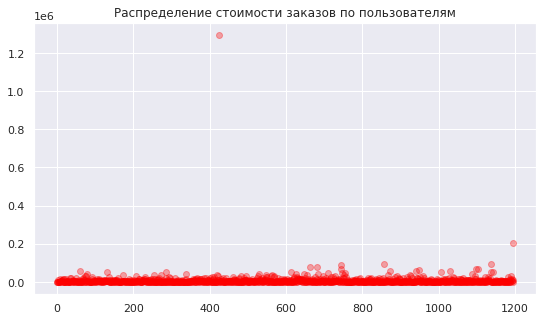

In [28]:
x_values = pd.Series(range(0,len(orders['revenue'])))

# строим точечную диаграмму
plt.scatter(x_values, orders['revenue'], color='red', alpha=0.33)
plt.title('Распределение стоимости заказов по пользователям')
plt.show()

**Снова видим этот гигантский заказ, который вызвал всплеск на графиках кумулятивных метрик, а так же другие весомые заказы, которые могут повлиять на результат исследований.**

**Пострим аналогичный график без двух крупных выбросов, которые заметили выше.**

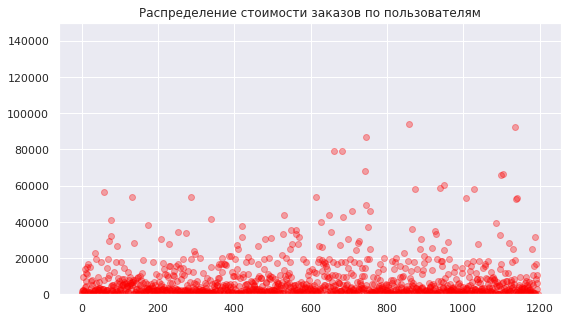

In [29]:
# строим точечную диаграмму
plt.ylim(0, 150000)
plt.scatter(x_values, orders['revenue'], color='red', alpha=0.33)
plt.title('Распределение стоимости заказов по пользователям')
plt.show()

**Видим, что стоимость основной массы заказов не превышает 20000.
Посчитаем 95-й и 99-й перцентили стоимости заказов на пользователя и выберим границу для определения аномалий.**

#### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [30]:
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


**Определяем границу по величине 99% перцентиля (58233.2).**

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

**Ранее мы результаты A/B-теста визуально и выяснили, что в данных, скорее всего, есть выбросы. Потом увидели выбросы и нашли границу для их определения.**

**Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.**

**Введем основную и альтернативные гипотезы:**

- H0: различий в среднем количестве заказов на посетителя между группами нет;
- H1: различия в среднем количестве заказов на посетителя между группами присутствуют.

**Уровень значимости α = 0.05.**

**Начнём с подготовки данных.**

**Так как данные о продажах и средних продажах редко бывают нормально распределены, для проверки гипотез используем непараметрический тест Уилкоксона-Манна-Уитни.
Для уровеня значимости установим стандартный уровень статистической значимости, равный 0.05.**


In [31]:
visitors_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_a.columns = ['date', 'visitors_per_date_a']

visitors_cummulative_a = visitors_daily_a.apply(
    lambda x: visitors_daily_a[visitors_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_a.columns = ['date', 'visitors_cummulative_a']

visitors_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_b.columns = ['date', 'visitors_per_date_b']

visitors_cummulative_b = visitors_daily_b.apply(
    lambda x: visitors_daily_b[visitors_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_b.columns = ['date', 'visitors_cummulative_b']

orders_daily_a = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_a.columns = ['date', 'orders_daily_a', 'revenue_per_date_a']

orders_cummulative_a = orders_daily_a.apply(
    lambda x: orders_daily_a[orders_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cummulative_a.columns = ['date','orders_cummulative_a','revenue_cummulative_a']

orders_daily_b = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_b.columns = ['date', 'orders_daily_b', 'revenue_per_date_b']

orders_cummulative_b = orders_daily_b.apply(
    lambda x: orders_daily_b[orders_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'orders_daily_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])

orders_cummulative_b.columns = ['date','orders_cummulative_b','revenue_cummulative_b']


data = (
    orders_daily_a.merge(
        orders_daily_b, left_on='date', right_on='date', how='left'
    )
    .merge(orders_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(orders_cummulative_b, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_a, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_b, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_b, left_on='date', right_on='date', how='left')
)

data.head(6)

,date,orders_daily_a,revenue_per_date_a,orders_daily_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280
5,2019-08-06,18,48484,28,242342,127,598401,129,824337,667,655,3985,3935


**У нас получилсь следующая таблица:**

- date — дата;
- orders_daily_a — количество заказов в выбранную дату в группе A;
- revenue_per_date_a — суммарная выручка в выбранную дату в группе A;
- orders_daily_a — количество заказов в выбранную дату в группе B;
- revenue_per_date_a — суммарная выручка в выбранную дату в группе B;
- orders_cummulative_a — суммарное число заказов до выбранной даты включительно в группе A;
- revenue_cummulative_a — суммарная выручка до выбранной даты включительно в группе A;
- orders_cummulative_b — суммарное количество заказов до выбранной даты включительно в группе B;
- revenue_cummulative_b — суммарная выручка до выбранной даты включительно в группе B;
- visitors_per_date_a — количество пользователей в выбранную дату в группе A;
- visitors_per_date_b — количество пользователей в выбранную дату в группе B;
- visitors_cummulative_a — количество пользователей до выбранной даты включительно в группе A;
- visitors_cummulative_b — количество пользователей до выбранной даты включительно в группе B .

**Создадим переменные orders_by_users_a и orders_by_users_a; в них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.**

In [32]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

**Объявим переменные sample_a и sample_b, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.**

In [33]:
sample_a = pd.concat([orders_by_users_a['orders'],
                      pd.Series(
                          0, 
                          index=np.arange(data['visitors_per_date_a'].sum() - 
                                          len(orders_by_users_a['orders'])), 
                          name='orders')],axis=0
                    )

sample_b = pd.concat([orders_by_users_b['orders'],
                      pd.Series(
                          0, 
                          index=np.arange(data['visitors_per_date_b'].sum() - 
                                          len(orders_by_users_b['orders'])), 
                          name='orders')],axis=0
                    )

Задаем функцию, в которой:

- Задаём уровень значимости alpha=0.05;
- Применим критерий Манна-Уитни;
- Отформатируем p-value, округлив его до трёх знаков после запятой;
- Выведем относительный прирост среднего числа заказов группы B: среднее число заказов группы B / среднее число заказов группы A - 1, округлив до трёх знаков после запятой.

In [34]:
# Функция для проверки гипотезы о равенстве групп data A и data B
def stat_significance(data_a, data_b):
    alpha = 0.05
    p_value = stats.mannwhitneyu(data_a, data_b)[1]
    print("P-value: {0:.3f}".format(p_value))

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между группами есть разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")
    
    print("Относительный прирост В к А: {0:.3%}".format(data_b.mean() / data_a.mean()-1))

In [35]:
stat_significance(sample_a, sample_b)

P-value: 0.017
Отвергаем нулевую гипотезу: между группами есть разница
Относительный прирост В к А: 13.808%


**По неочищенным данным различия в среднем количестве заказов между группами есть.
P-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем количестве заказов между группами нет, отвергаем. Относительный выигрыш группы B равен 13.808%.**

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 

**Посчитаем статистическую значимость различий в среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.**

**Введем основную и альтернативную гипотезы:**
- H0: различий в среднем чеке между группами нет;
- H1: различия в среднем чеке между группами есть.

**Уровень значимости α = 0.05.**

**Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов. А ещё найдём относительные различия в среднем чеке между группами.**

In [36]:
stat_significance(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])

P-value: 0.729
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительный прирост В к А: 25.871%


**P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A.**

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

**Примем за аномальных пользователей тех, кто совершил от 5 заказов или совершил заказ дороже 58233. Так мы уберём 1% пользователей с наибольшим числом заказов и от 1% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 4 — users_with_many_orders и пользователей, совершивших заказы дороже 58233.2 — users_with_expensive_orders. Объединим их в таблице abnormal_users.
Узнаем, сколько всего аномальных пользователей методом shape().**

In [37]:
many_orders = np.percentile(orders_by_users['orders'], 99)
expensive_orders = np.percentile(orders['revenue'], 99)


users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > many_orders]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > many_orders]['visitor_id'],
    ],
    axis=0,
)


users_with_expensive_orders = orders[orders['revenue'] > expensive_orders]['visitor_id']


abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormal_users.head(5))
abnormal_users.shape[0]

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
Name: visitor_id, dtype: int64

15

**Всего 15 аномальных пользователей.
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста.**

In [38]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [39]:
stat_significance(sample_a_filtered, sample_b_filtered)

P-value: 0.014
Отвергаем нулевую гипотезу: между группами есть разница
Относительный прирост В к А: 15.331%


**На очищенных данных разница в среднем количестве заказов между группами есть, а относительный прирост группы В относительно группы А увеличился на 15.331%.**

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

In [40]:
stat_significance(
    orders[(orders['group']=='A') & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue'], 
    orders[(orders['group']=='B') & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue']
)

P-value: 0.851
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными
Относительный прирост В к А: -0.575%


**P-value больше 0.05. Следовательно, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. По разнице средних чеков групп различий практически нет.**

### Вывод.

**На основании входных данных, предоставленных интернет-магазином был проведено исследование и сделаны следующие выводы:**

**1. В части приоритизации, в первую очередь следует обратить внимание на гипотезы:**
 - "Запустить акцию, дающую скидку на товар в день рождения";
 - "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей";
 - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок";
 - "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию";
 - "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа".
 
**Если ранжирование гипотез должно включать в себя и охват пользователей интернет-магазина, то места необходимо распределить таким образом:**
 - "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок";
 - "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа";
 - "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей";
 - "Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию";
 - "Запустить акцию, дающую скидку на товар в день рождения".
 
**2. В части анализа A/B теста:**
  
 - Куммулятивная выручка группы А растет линейно, и она меньше, чем у группы В;
 - Большинство пользователей оформляли заказ один раз, Много пользователей с 2-3 заказами, выбрали границу в 4 заказа как "потолок" для определения аномальных пользователей;
 - Не более 5% пользователей совершали больше 2-х покупок в течение тестирования. И только 1% - четыре и более;
 - Сначала среднее количество заказов на посетителя колебалось, но довольно быстро выровнялись. Везультат группы В выглядит более привлекательным;
 - В начале теста группа В проигрывала группе А в среднем количестве заказов на пользователя, но затем вырвалась вперед. Ее куммулятивная метрика стремительно росла, далее начался медленный спад. Под конец исследуемого периода куммулятивное количество заказов группы В снова растет;
 - Средняя стоимость заказа 8 348, максимальная 1 294 500, стоимость основной массы заказов не превышает 20000;
 - Выбрали границу по стоимости в 58233.2;
 - По неочищенным данным различия в среднем количестве заказов между группами есть. Относительный выигрыш группы B равен 13.808%;
 - Причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A;
 - Всего 15 аномальных пользователей;
 - На очищенных данных разница в среднем количестве заказов между группами есть, а относительный прирост группы В относительно группы А увеличился на 15.331%.
 - Причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. По разнице средних чеков групп различий практически нет.

**На основании вышеизложенного рекомендую остановить тест, зафиксировав победу группы B: её результаты лучше чем у оппонентов.**